In [71]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt
from equations import *
from functions import read_and_clean_dataset, open_input_file, generate_dataset

In [73]:
path = '../data/synthetic_dataset/'
file_list = ['SWin','SWout', 'LWin', 'Tair', 'RH_air', 'wind_speed', 'total_precipitation', 'snow_cover_fraction']
variable_list = ['SWin','SWout', 'LWin', 'Tair', 'RH_air', 'u', 'prec', 'snow_cover']

for i, variable_name in enumerate(file_list):
    if i == 0: data = pd.read_csv(path + variable_name + '.csv', index_col="time", parse_dates=True)
    else: data[variable_list[i]] = pd.read_csv(path + variable_name + '.csv', index_col="time", parse_dates=True)[variable_list[i]]

#data

In [120]:
def T_constrain(Tair, total_precipitation, wind_speed, snow_cover, albedo, time_of_day=0):
    """
    Calculate surface temperature based on various meteorological parameters.
    
    Parameters:
    - Tair: Near surface air temperature [K]
    - total_precipitation: Precipitation rate [kg/m2/s]
    - wind: Wind speed [m/s]
    - time_of_day: Time of day in hours (0-24)
    - snow_cover: Snow cover fraction (0-1), default 0
    - albedo: Surface albedo (0-1), default 0.3
    
    Returns:
    - Surface temperature [K]
    """
    
    # Constants (these can be adjusted based on local conditions)
    A = 10  # Amplitude of diurnal temperature variation [K]
    B = 5   # Snow cover effect coefficient [K]
    C = 5000  # Precipitation effect coefficient [K/(kg/m2/s)]
    D = 2   # Wind effect coefficient [K]
    
    # Solar radiation effect
    #if not time_of_day == 0: delta_T_solar = A * np.sin(2 * np.pi * time_of_day / 24) * (1 - albedo)
    #else : delta_T_solar = 0
    
    # Snow cover effect
    delta_T_snow = -B * snow_cover
    
    # Precipitation effect
    delta_T_precip = -C * total_precipitation
    
    # Wind effect
    delta_T_wind = -D * np.log(1 + wind_speed)
    
    # Calculate surface temperature
    T_surface = Tair + delta_T_snow + delta_T_precip + delta_T_wind #+ delta_T_solar
    
    return T_surface

In [126]:
# Function to solve for Ts at each time step
def solve_Ts(SWin, SWout, LWin, Tair, RH_air, u, prec, snow_cover):
    
    # Define the equation to solve
    def equation_system(Ts):
        
        LWout = longwave_out(Ts)
        SH = sensible_heat_flux(u, Ts, Tair)
        RH_s = surface_relative_humidity(RH_air, Ts, Tair, prec, snow_cover, u)
        q_s = specific_humidity(Ts, RH_s)
        q_air = specific_humidity(Ts, RH_air)
        LE = latent_heat_flux(u, q_s, q_air)
        Ts = T_constrain(Tair, prec, u, snow_cover, albedo=0.3)

        return energy_balance(SWin, SWout, LWin, LWout, SH, LE)
        

    # Initial guess for Ts (e.g., ambient air temperature)
    initial_guess = Tair
    solution = root(equation_system, initial_guess)

    # Check if the solution converged
    if solution.success:
        return solution.x[0]
    else:
        raise ValueError("Solution did not converge")

# Assuming the solve_Ts function is already defined

def calculate_surface_temperatures(df):
    """
    Calculate surface temperatures using the time series data from a DataFrame.

    Parameters:
        df (DataFrame): DataFrame with columns: 'SWin', 'SWout', 'LWin', 'Tair', 'u', 'q_air', 'RHs'

    Returns:
        np.array: Array of calculated surface temperatures (Ts) for each row in the DataFrame.
    """
    Ts_values = []
    for _, row in df.iterrows():
        Ts = solve_Ts(
            SWin=row['SWin'], 
            SWout=row['SWout'], 
            LWin=row['LWin'], 
            Tair=row['Tair'], 
            u=row['u'], 
            RH_air=row['RH_air'], 
            prec =row['prec'], 
            snow_cover =row['snow_cover']
        )
        Ts_values.append(Ts)
    return pd.DataFrame({'Ts': Ts_values}, index=df.index)#np.array(Ts_values)

# Example: Calculate Ts for each time step
Ts_values = calculate_surface_temperatures(data)

In [ ]:
# Function to solve for Ts at each time step
def solve_Ts(SWin, SWout, LWin, Tair, RH_air, u, prec, snow_cover):
    
    # Define the equation to solve
    def equation_system(Ts):
        
        LWout = longwave_out(Ts)
        SH = sensible_heat_flux(u, Ts, Tair)
        RH_s = surface_relative_humidity(RH_air, Ts, Tair, prec, snow_cover, u)
        q_s = specific_humidity(Ts, RH_s)
        q_air = specific_humidity(Ts, RH_air)
        LE = latent_heat_flux(u, q_s, q_air)

        return energy_balance(SWin, SWout, LWin, LWout, SH, LE)

    # Define constraints
    #def constraint(Ts):
        # Limit Ts to be within a certain range of Tair
        # For example, Ts should not be more than 20°C higher or lower than Tair
        #delta_T = 10
        #return min(max(Tair - delta_T, Ts[0]), Tair + delta_T) - Ts[0]

    # Initial guess for Ts (e.g., ambient air temperature)
    initial_guess = Tair

    # Solve the equation with constraints
    solution = root(lambda x: [equation_system(x[0]), T_constrain(Tair, prec, u, snow_cover, albedo=0)], [initial_guess]) #constraint(x)

    # Initial guess for Ts (e.g., ambient air temperature)
    #initial_guess = Tair
    #solution = root(equation_system, initial_guess)

    # Check if the solution converged
    if solution.success:
        return solution.x[0]
    else:
        raise ValueError("Solution did not converge")

In [108]:
def solve_Ts(SWin, SWout, LWin, Tair, RH_air, u, prec, snow_cover):
    """
    Solve for surface temperature (Ts) with constraints linked to Tair and other variables.
    """
    # Define the equation to solve
    def equation_system(Ts):
        LWout = longwave_out(Ts)
        SH = sensible_heat_flux(u, Ts, Tair)
        RH_s = surface_relative_humidity(RH_air, Ts, Tair, prec, snow_cover, u)
        q_s = specific_humidity(Ts, RH_s)
        q_air = specific_humidity(Ts, RH_air)
        LE = latent_heat_flux(u, q_s, q_air)

        return energy_balance(SWin, SWout, LWin, LWout, SH, LE)

    # Initial guess for Ts (e.g., ambient air temperature)
    initial_guess = Tair

    # Solve the system
    solution = root(equation_system, initial_guess)

    # Check if the solution converged
    if solution.success:
        Ts = solution.x[0]

        # Apply constraints
        if snow_cover > 0.5:  # High snow cover: limit Ts deviation
            Ts = max(min(Ts, Tair + 2), Tair - 2)  # Allow a 2 K deviation from Tair
        elif prec > 0:  # During precipitation: keep Ts closer to Tair
            Ts = max(min(Ts, Tair + 5), Tair - 5)  # Allow a 5 K deviation from Tair
        else:  # No snow/precip: allow more variability
            Ts = max(min(Ts, Tair + 10), Tair - 10)  # Allow up to 10 K deviation

        return Ts
    else:
        raise ValueError("Solution did not converge")

In [128]:
# Assuming the solve_Ts function is already defined

def calculate_surface_temperatures(df):
    """
    Calculate surface temperatures using the time series data from a DataFrame.

    Parameters:
        df (DataFrame): DataFrame with columns: 'SWin', 'SWout', 'LWin', 'Tair', 'u', 'q_air', 'RHs'

    Returns:
        np.array: Array of calculated surface temperatures (Ts) for each row in the DataFrame.
    """
    Ts_values = []
    for _, row in df.iterrows():
        Ts = solve_Ts(
            SWin=row['SWin'], 
            SWout=row['SWout'], 
            LWin=row['LWin'], 
            Tair=row['Tair'], 
            u=row['u'], 
            RH_air=row['RH_air'], 
            prec =row['prec'], 
            snow_cover =row['snow_cover']
        )
        Ts_values.append(Ts)
    return pd.DataFrame({'Ts': Ts_values}, index=df.index)#np.array(Ts_values)

# Example: Calculate Ts for each time step
Ts_values = calculate_surface_temperatures(data)

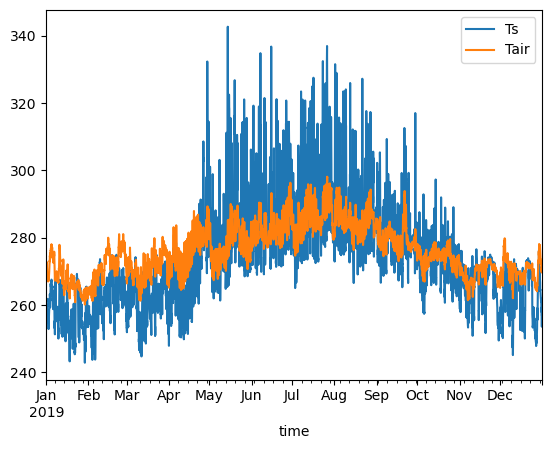

In [129]:
Ts_values.plot()

data['Tair'].plot(label = 'Tair')
plt.legend()

it actually does make sense for the surface temperature to have a larger amplitude than air temperature in a time series. Here's why:
Thermal properties: The Earth's surface (soil, rock, vegetation, etc.) has different thermal properties compared to air. It typically has a lower specific heat capacity, meaning it can heat up and cool down more quickly than air.
Direct solar radiation: The surface directly absorbs solar radiation during the day, causing it to heat up more rapidly and to higher temperatures than the air above it. At night, the surface radiates heat more efficiently than air, allowing it to cool more quickly.
Atmospheric buffering: The air temperature is buffered by various factors such as wind, humidity, and atmospheric mixing, which tend to moderate temperature extremes. The surface doesn't benefit from these buffering effects to the same extent.
Diurnal cycle: During a typical day-night cycle, the surface temperature often shows a more pronounced variation:
During the day, especially under clear sky conditions, the surface can become much warmer than the air above it.
At night, especially under clear, calm conditions, the surface can cool more rapidly than the air through radiative cooling.
Urban heat island effect: In urban areas, surfaces like asphalt and concrete can reach much higher temperatures during the day and cool more at night compared to air temperatures.
Microclimates: Surface temperatures can vary significantly over short distances due to factors like shading, moisture content, and surface type, leading to larger local temperature amplitudes.
Seasonal effects: On a seasonal scale, surfaces exposed to direct sunlight can show larger temperature swings than air temperatures, especially in areas with high solar radiation and low atmospheric moisture.
Measurement considerations: Surface temperature is often measured by infrared thermometers or satellite sensors, which capture the skin temperature of the surface. This can show more extreme values than air temperature measured at standard heights (usually 1.5-2 meters above the ground).
Given these factors, it is quite common and expected for surface temperature to show larger amplitudes than air temperature in many environments. This larger amplitude in surface temperature is an important factor in many environmental and ecological processes, including energy balance, evapotranspiration, and ecosystem dynamics.

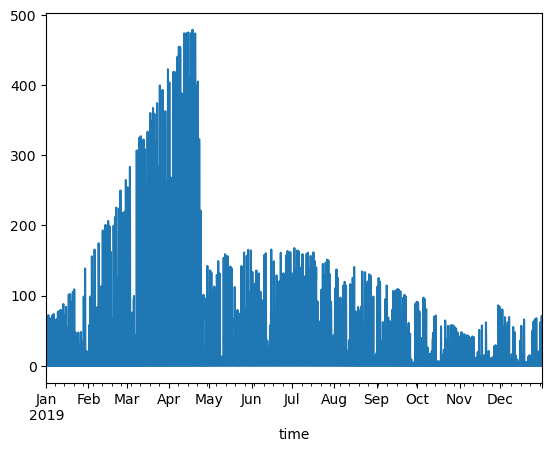

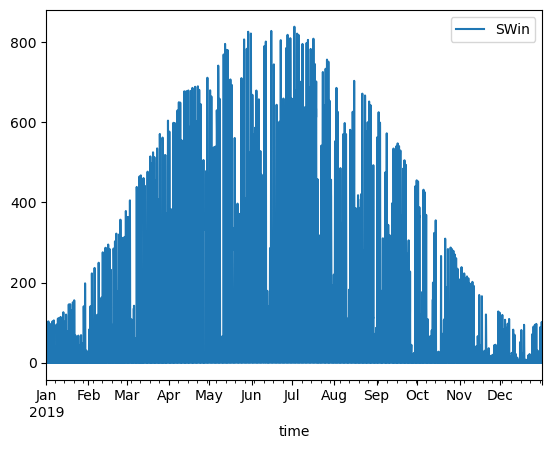

In [5]:
SWout.plot()
SWin.plot()
#snow_cover.plot()
plt.plot(LWin.index, LWin['LWin'])

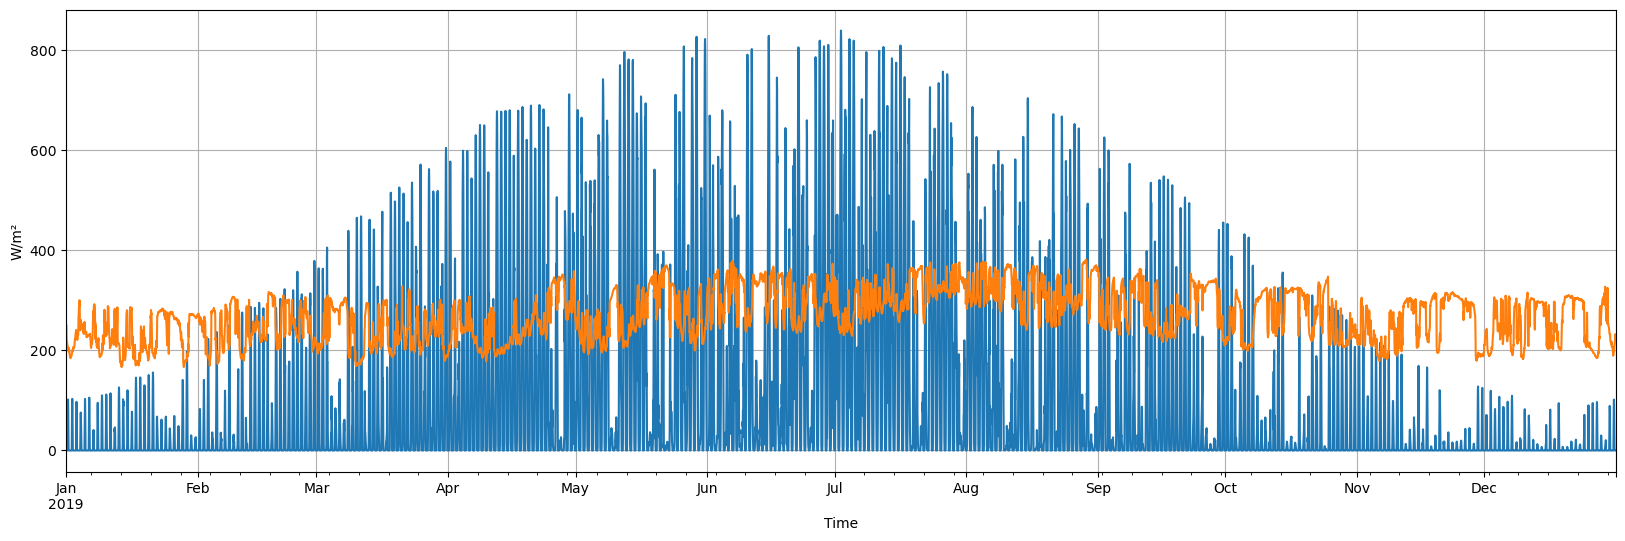

In [37]:
SWin['SWin'].plot(figsize=(20, 6))
LWin['LWin'].plot(ylabel="W/m²", xlabel="Time")
plt.grid()
plt.show()